In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch
from sklearn.metrics import r2_score

import constant
from constant import org_cols, wsr_cols, geo_pow_cols, semigeo_cols
import myplot
from models import model_evaluation, model_improvement, get_days_error, NRMSE_all, RMSE_all
path = "PH_SC_1/"
model_path = constant.model_path + path
plot_path = constant.plot_path + path
error_path = constant.error_path + path


In [2]:
%load_ext autoreload

# Evaluation

## load evaluation data, models, features

In [3]:
df_evl = pd.read_parquet(constant.PH_SC_EVL_path)
df_evl["TIME_CET"] = pd.to_datetime(df_evl["TIME_CET"])

In [4]:
model_original = torch.load(model_path + "original_model.pth")
model_wsr = torch.load(model_path + "wsr_model.pth")
model_geo = torch.load(model_path + "geo_model.pth")
model_semigeo = torch.load(model_path + "semigeo_model.pth")

In [5]:
# ahead = "Days_Ahead0_"
# original_errs= model_evaluation(df_evl, org_cols, model_original)
# wsr_errs= model_evaluation(df_evl, wsr_cols, model_wsr)
# geo_errs= model_evaluation(df_evl, geo_pow_cols, model_geo)
# semigeo_errs= model_evaluation(df_evl, semigeo_cols, model_semigeo)

In [6]:
ahead = "Days_Ahead1_"
original_errs= model_evaluation(df_evl, org_cols, model_original, ahead=1)
wsr_errs= model_evaluation(df_evl, wsr_cols, model_wsr, ahead=1)
geo_errs= model_evaluation(df_evl, geo_pow_cols, model_geo, ahead=1)
semigeo_errs= model_evaluation(df_evl, semigeo_cols, model_semigeo, ahead=1)

## RMSE

In [7]:
time = original_errs.index+1

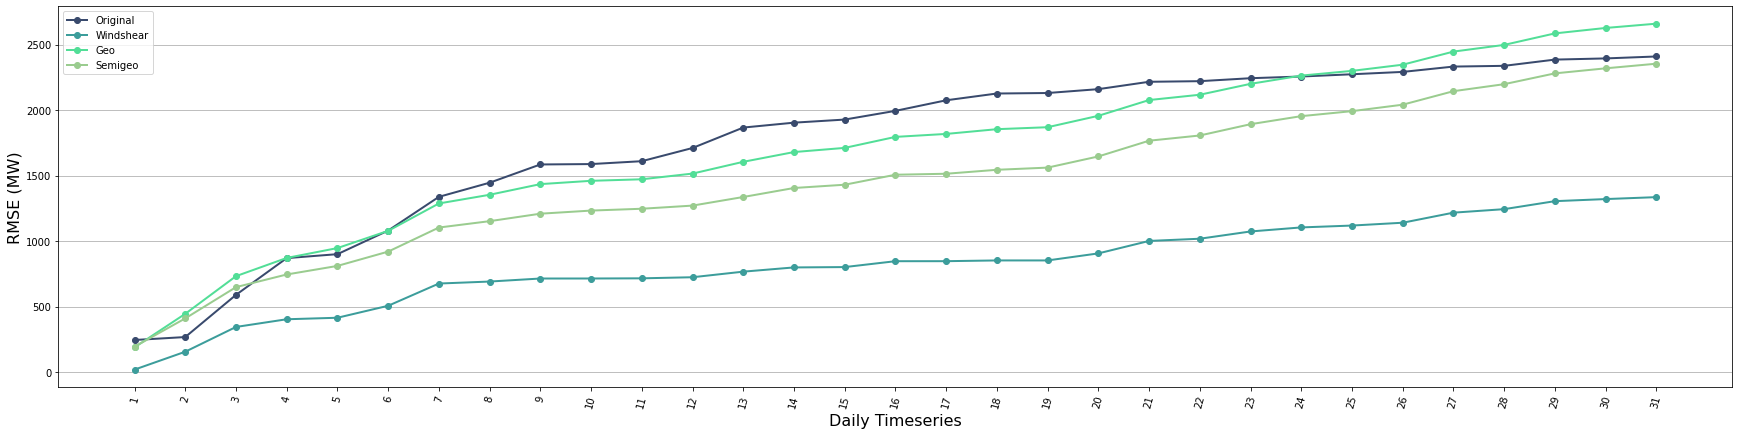

In [8]:
myplot.timelines(time, 
{"Original":original_errs["RMSE"], "Windshear":wsr_errs["RMSE"], "Geo":geo_errs["RMSE"], "Semigeo":semigeo_errs["RMSE"]}, ylabel="RMSE (MW)", xlabel="Daily Timeseries",path=plot_path+ahead+"RMSE.png")

In [9]:
# myplot.timelines(original_errs.index, 
# {"Original":original_errs["NRMSE"], "Windshear":wsr_errs["NRMSE"], "Geo":geo_errs["NRMSE"], "Semigeo":semigeo_errs["NRMSE"]}, ylabel="NRMSE (MW)", fulltime=False, path=plot_path+ahead+"NRMSE_Days.png")

### Error Distribution

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [11]:
def err_distribution(df, path):
    plt.plot(figsize=(6, 6))
    df = round(df, 0)
    y = df.groupby("RMSE", as_index=False)["VAERDI"].count()
    y = y[y["VAERDI"]>0]
    x = range(0, len(y))
    plt.bar(x, y["VAERDI"], width=0.5)
    plt.xticks(x, y["RMSE"].to_list(),rotation=70)
    plt.yticks(range(y["VAERDI"].max()+1))
    plt.ylabel("Number of Samples", fontsize=13)
    plt.xlabel("RMSE(MW)", fontsize=13)
    if path is not None:
        plt.savefig(path, dpi=150, bbox_inches='tight')

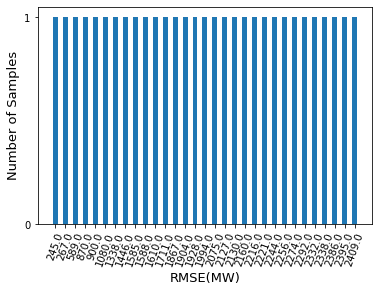

In [12]:
err_distribution(original_errs, path=plot_path+ahead+"OGN_Errdisb.png")

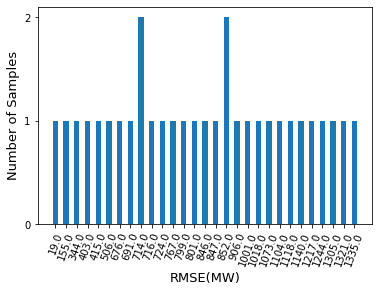

In [13]:
err_distribution(wsr_errs,path=plot_path+ahead+"WSR_Errdisb.png")

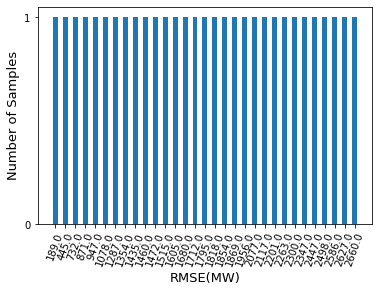

In [14]:
err_distribution(geo_errs, path=plot_path+ahead+"GEO_Errdisb.png")

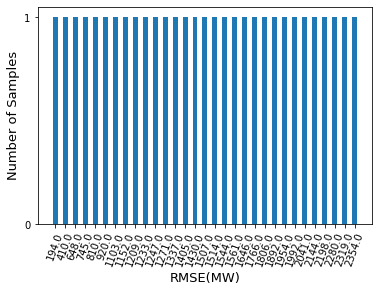

In [15]:
err_distribution(semigeo_errs, path=plot_path+ahead+"SEMIGEO_Errdisb.png")

## Prediction

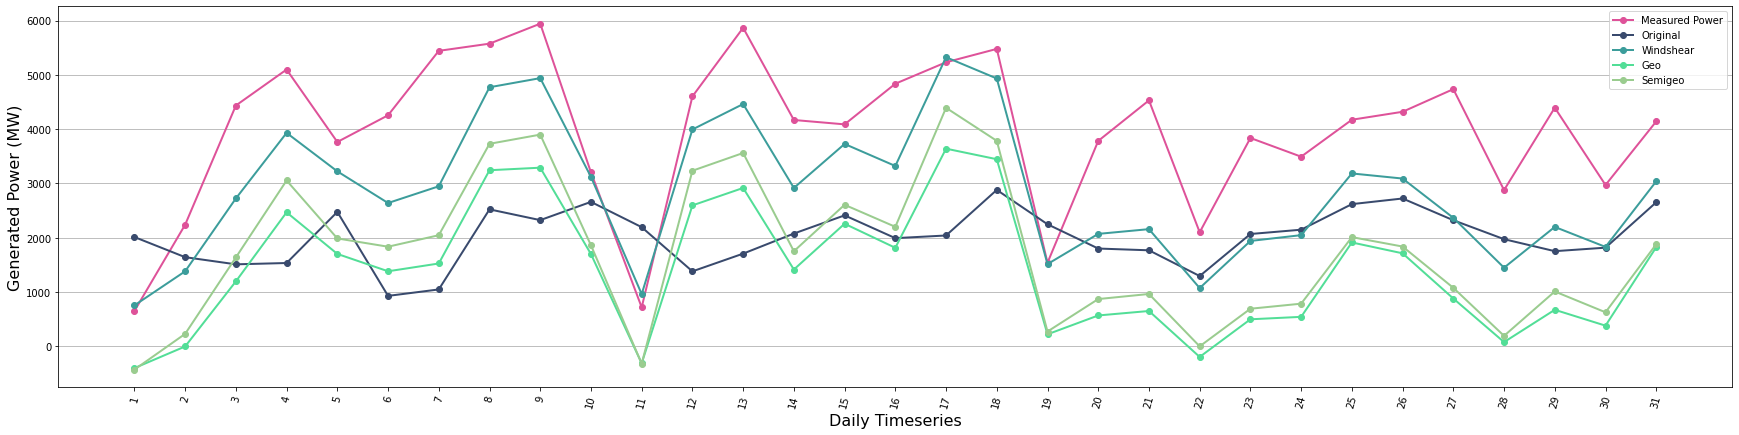

In [16]:
myplot.timelines(time, 
{"Measured Power":original_errs["VAERDI"], "Original":original_errs["pred"], "Windshear":wsr_errs["pred"], "Geo":geo_errs["pred"], "Semigeo":semigeo_errs["pred"]}, ylabel="Generated Power (MW)",xlabel="Daily Timeseries",  path=plot_path+ahead+"Power.png")

## Model Comparement

In [17]:
print(RMSE_all(original_errs))
print(RMSE_all(wsr_errs))
print(RMSE_all(geo_errs))
print(RMSE_all(semigeo_errs))

2409.4962096540953
1335.4824144806298
2659.9163274438565
2354.2688538947696


In [18]:
imp_RMSE, r2 = model_improvement({"Original": original_errs, "Windshear": wsr_errs, "Geo": geo_errs, "Semigeo": semigeo_errs}, "RMSE")
r2

{'Original': -2.146, 'Windshear': 0.034, 'Geo': -2.834, 'Semigeo': -2.003}

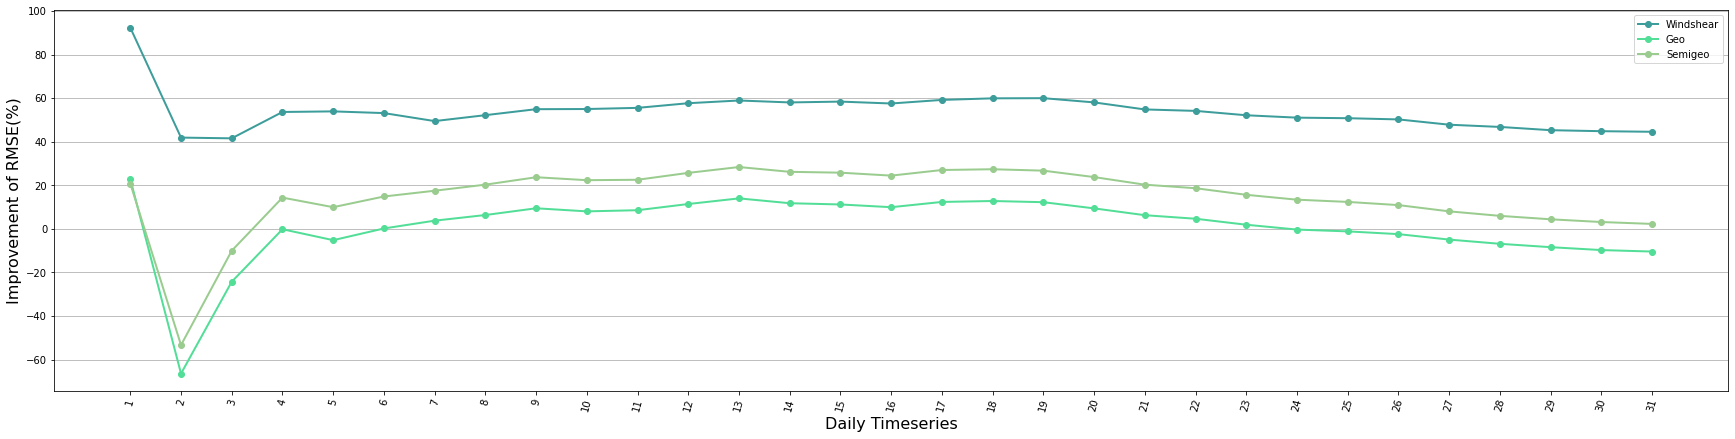

In [19]:
myplot.timelines(time, 
{"Windshear":imp_RMSE["Windshear"]["Original"], "Geo":imp_RMSE["Geo"]["Original"], "Semigeo":imp_RMSE["Semigeo"]["Original"]}, ylabel="Improvement of RMSE(%)",xlabel="Daily Timeseries",path=plot_path+ahead+"Improvement_RMSE.png")